# GPT-2 Model Size Test

## 工作回顧 2021-10-01

總結之前的工作，已經可以用 pre-trianed 的 GPT-2 模型來 fine-tune，也測試過幾個文本訓練的結果，在這裡稍微總結一下心得。

### Fine-tune with New Corpus

目前測試都是基於 [CKIP 的 pretrained GPT-2](https://huggingface.co/ckiplab/gpt2-base-chinese)，再以新語料搭配 [run_clm.py](https://github.com/huggingface/transformers/blob/master/examples/pytorch/language-modeling/run_clm.py) 來微調（注意：不同版本的 run_clm.py 內容略有不同）。

微調過的模型有：
- 以「古龍全集」微調
- 以「瓊瑤全集」微調
- 以「唐詩宋詞」微調
- 以「古龍全集」＋「梁羽生全集」＋「唐詩宋詞」＋「瓊瑤全集」微調

心得：
- 直接以「唐詩宋詞」訓練新的模型，生成的文字非常不流暢，微調的版本才有較通順的語意
- 微調後模型生成文字的結果，受最後訓練的文本影響很大。以前面的實驗為例，如果最後的文本是瓊瑤全集，那麼生成文字就非常瓊瑤。
- 語料中的人名、地名會被記憶住，瓊瑤全集最後一本的主角姓名就一直在生成文本裡出現。

未來可以修正的作法：
- 將長文本切割成較短的「段落」，然後隨機排列
- 將不欲學習的人名、地名以遮罩蓋掉


## 從頭訓練新模型

目前使用的 [CKIP pretrained GPT-2](https://huggingface.co/ckiplab/gpt2-base-chinese)模型，架構是使用[huggingface 預設的 GPT2Config](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2config)，實際儲存空間大約 500Mb左右。這個大小的模型在 fine-tune 的過程常常會造成 GPU記憶體不足，因此我們想測試縮小模型的架構。

在[Chinese NewsTitle Generation Project by GPT2.带有超级详细注释的中文GPT2新闻标题生成项目。](https://pythonrepo.com/repo/liucongg-GPT2-NewsTitle) 這篇裡，使用了較小的模型結構：層數從 12 降到 6，模擬文字長度從 1024 降為 512。我們來測試看看實際模型大小：


In [1]:
import logging
import os
import random
import sys
import numpy as np
import tensorflow as tf
from transformers import BertTokenizerFast, TFGPT2LMHeadModel, GPT2Config
import pandas as pd

myconfig = GPT2Config(
                n_ctx=512,
                n_embd=768,
                n_head=12,
                n_layer=6,
                n_positions=512,
                vocab_size=13317
            )

tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
model = TFGPT2LMHeadModel(myconfig)

C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\tsyo\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
#path_tokenizer = '../model/tokenizer/'
#path_model = '../model/mygpt2_01'
#tokenizer.save_pretrained(path_tokenizer)
#model.save_pretrained(path_model)

上面這個未經訓練的模型，儲存空間大約是 7kb，讓我們用小文本稍作訓練，看看結果如何。

In [2]:
import re, os, json

cfile = '../data/poet.song.0.json'

with open(cfile, 'r') as f:
    tmp = json.load(f)

print(len(tmp))
print(tmp[101])

1000
{'author': '釋延壽', 'paragraphs': ['忙處須閒淡處濃，世情疏後道情通。', '了然得旨青冥外，兀爾虛心罔象中。', '泉細石根飛不盡，雲濛山脚出無窮。', '樵夫釣客雖閒散，未必真棲與我同。'], 'title': '山居詩  其二一', 'id': '6622eb2e-609a-4baa-a8a1-035c4e2229c0'}


In [3]:
poems = [''.join(a['paragraphs']) for a in tmp]
print(len(poems))
print(poems[101])
print(tokenizer.encode(poems[101]))

with open('../data/poet.song.0.txt', 'w') as f:
    f.write('\n'.join(poems))

1000
忙處須閒淡處濃，世情疏後道情通。了然得旨青冥外，兀爾虛心罔象中。泉細石根飛不盡，雲濛山脚出無窮。樵夫釣客雖閒散，未必真棲與我同。
[101, 2564, 5993, 7519, 7278, 3909, 5993, 4083, 8024, 686, 2658, 4541, 2527, 6887, 2658, 6858, 511, 749, 4197, 2533, 3192, 7471, 1097, 1912, 8024, 1037, 4273, 5995, 2552, 5382, 6496, 704, 511, 3787, 5169, 4767, 3418, 7606, 679, 4674, 8024, 7437, 4088, 2255, 5558, 1139, 4192, 4981, 511, 3570, 1923, 7037, 2145, 7426, 7278, 3141, 8024, 3313, 2553, 4696, 3483, 5645, 2769, 1398, 511, 102]


(array([976,  15,   4,   1,   0,   0,   1,   1,   0,   2], dtype=int64), array([  6. , 102.6, 199.2, 295.8, 392.4, 489. , 585.6, 682.2, 778.8,
       875.4, 972. ]))


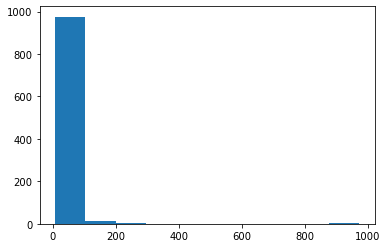

In [4]:
plength = [len(p) for p in poems]

import numpy as np
print(np.histogram(plength))

%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(plength)
plt.show()

## 1000 首詩的長度

由上面的 histogram 可以看到，這1000首詩中有 976 首的長度是小於 103個字，如果限制在 256字以內，則包含了 996 首。 

In [5]:
# Create datasets for training

#change eos and bos tokens
special_tokens_dict = {'bos_token':"[start]", 'eos_token':"[end]"}
tokenizer.add_special_tokens(special_tokens_dict)

# Tokenize corpus
examples = []
block_size = 128
for poem in poems:
    if len(poem)<block_size: 
        examples.append(tokenizer.encode(poem))
    else:                           # Truncate in block of block_size
        for i in range(0, len(poem)-block_size+1, block_size):
            end = min(i+block_size, len(poem))
            examples.append(tokenizer.encode(poem[i:end]))
print(len(examples))

# Build x,y for training
inputs, labels = [], []
for ex in examples:
    inputs.append(ex[:-1])
    labels.append(ex[1:])

rx = tf.ragged.constant(inputs).to_tensor()        # Fixing for the non-rectangular matrix error
ry = tf.ragged.constant(labels).to_tensor()

print(rx.shape)
print(ry.shape)

dataset= tf.data.Dataset.from_tensor_slices((rx, ry))

BATCH_SIZE = 16
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

1023
(1023, 129)
(1023, 129)


In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

def dummy_loss(y_true, y_pred):
    return tf.reduce_mean(y_pred)

model.compile(optimizer=optimizer, loss={"loss": dummy_loss})

history = model.fit(
    dataset,
    epochs=1000,
    batch_size=BATCH_SIZE,
    steps_per_epoch=int(1023/BATCH_SIZE)
)

Epoch 1/1000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


63/63 [==============================] - 6s 15ms/step - loss: -0.5165 - past_key_values_1_loss: -0.5165
Epoch 2/1000
63/63 [==============================] - 1s 14ms/step - loss: -2.3799 - past_key_values_1_loss: -2.3799
Epoch 3/1000
63/63 [==============================] - 1s 14ms/step - loss: -5.2375 - past_key_values_1_loss: -5.2375
Epoch 4/1000
63/63 [==============================] - 1s 14ms/step - loss: -8.5239 - past_key_values_1_loss: -8.5239
Epoch 5/1000
63/63 [==============================] - 1s 14ms/step - loss: -11.9209 - past_key_values_1_loss: -11.9209
Epoch 6/1000
63/63 [==============================] - 1s 13ms/step - loss: -15.3170 - past_key_values_1_loss: -15.3170
Epoch 7/1000
63/63 [==============================] - 1s 13ms/step - loss: -18.6865 - past_key_values_1_loss: -18.6865
Epoch 8/1000
63/63 [==============================] - 1s 14ms/step - loss: -22.0145 - past_key_values_1_loss: -22.0145
Epoch 9/1000
63/63 [==============================] - 1s 14ms/step - 

63/63 [==============================] - 1s 13ms/step - loss: -278.9584 - past_key_values_1_loss: -278.9584
Epoch 69/1000
63/63 [==============================] - 1s 14ms/step - loss: -284.3597 - past_key_values_1_loss: -284.3597
Epoch 70/1000
63/63 [==============================] - 1s 14ms/step - loss: -289.7878 - past_key_values_1_loss: -289.7878
Epoch 71/1000
63/63 [==============================] - 1s 14ms/step - loss: -295.2732 - past_key_values_1_loss: -295.2732
Epoch 72/1000
63/63 [==============================] - 1s 13ms/step - loss: -300.7657 - past_key_values_1_loss: -300.7657
Epoch 73/1000
63/63 [==============================] - 1s 14ms/step - loss: -306.3083 - past_key_values_1_loss: -306.3083
Epoch 74/1000
63/63 [==============================] - 1s 14ms/step - loss: -311.8713 - past_key_values_1_loss: -311.8713
Epoch 75/1000
63/63 [==============================] - 1s 13ms/step - loss: -317.4699 - past_key_values_1_loss: -317.4699
Epoch 76/1000
63/63 [=================

Epoch 135/1000
63/63 [==============================] - 1s 13ms/step - loss: -713.9070 - past_key_values_1_loss: -713.9070
Epoch 136/1000
63/63 [==============================] - 1s 13ms/step - loss: -721.4911 - past_key_values_1_loss: -721.4911
Epoch 137/1000
63/63 [==============================] - 1s 13ms/step - loss: -729.1245 - past_key_values_1_loss: -729.1245
Epoch 138/1000
63/63 [==============================] - 1s 13ms/step - loss: -736.7863 - past_key_values_1_loss: -736.7863
Epoch 139/1000
63/63 [==============================] - 1s 13ms/step - loss: -744.4835 - past_key_values_1_loss: -744.4835
Epoch 140/1000
63/63 [==============================] - 1s 14ms/step - loss: -752.1876 - past_key_values_1_loss: -752.1876
Epoch 141/1000
63/63 [==============================] - 1s 13ms/step - loss: -759.9363 - past_key_values_1_loss: -759.9363
Epoch 142/1000
63/63 [==============================] - 1s 13ms/step - loss: -767.7095 - past_key_values_1_loss: -767.7095
Epoch 143/1000
6

63/63 [==============================] - 1s 14ms/step - loss: -1273.1361 - past_key_values_1_loss: -1273.1361
Epoch 201/1000
63/63 [==============================] - 1s 14ms/step - loss: -1282.7572 - past_key_values_1_loss: -1282.7572
Epoch 202/1000
63/63 [==============================] - 1s 13ms/step - loss: -1292.4019 - past_key_values_1_loss: -1292.4019
Epoch 203/1000
63/63 [==============================] - 1s 13ms/step - loss: -1302.1268 - past_key_values_1_loss: -1302.1268
Epoch 204/1000
63/63 [==============================] - 1s 14ms/step - loss: -1311.8926 - past_key_values_1_loss: -1311.8926
Epoch 205/1000
63/63 [==============================] - 1s 14ms/step - loss: -1321.6169 - past_key_values_1_loss: -1321.6169
Epoch 206/1000
63/63 [==============================] - 1s 13ms/step - loss: -1331.4459 - past_key_values_1_loss: -1331.4459
Epoch 207/1000
63/63 [==============================] - 1s 13ms/step - loss: -1341.2417 - past_key_values_1_loss: -1341.2417
Epoch 208/1000


63/63 [==============================] - 1s 13ms/step - loss: -1953.0569 - past_key_values_1_loss: -1953.0569
Epoch 265/1000
63/63 [==============================] - 1s 13ms/step - loss: -1964.7245 - past_key_values_1_loss: -1964.7245
Epoch 266/1000
63/63 [==============================] - 1s 13ms/step - loss: -1976.3574 - past_key_values_1_loss: -1976.3574
Epoch 267/1000
63/63 [==============================] - 1s 13ms/step - loss: -1988.0660 - past_key_values_1_loss: -1988.0660
Epoch 268/1000
63/63 [==============================] - 1s 13ms/step - loss: -1999.7795 - past_key_values_1_loss: -1999.7795
Epoch 269/1000
63/63 [==============================] - 1s 13ms/step - loss: -2011.5725 - past_key_values_1_loss: -2011.5725
Epoch 270/1000
63/63 [==============================] - 1s 13ms/step - loss: -2023.3557 - past_key_values_1_loss: -2023.3557
Epoch 271/1000
63/63 [==============================] - 1s 13ms/step - loss: -2035.1632 - past_key_values_1_loss: -2035.1632
Epoch 272/1000


63/63 [==============================] - 1s 13ms/step - loss: -2760.0146 - past_key_values_1_loss: -2760.0146
Epoch 329/1000
63/63 [==============================] - 1s 13ms/step - loss: -2773.6870 - past_key_values_1_loss: -2773.6870
Epoch 330/1000
63/63 [==============================] - 1s 13ms/step - loss: -2787.2854 - past_key_values_1_loss: -2787.2854
Epoch 331/1000
63/63 [==============================] - 1s 14ms/step - loss: -2800.9746 - past_key_values_1_loss: -2800.9746
Epoch 332/1000
63/63 [==============================] - 1s 13ms/step - loss: -2814.6794 - past_key_values_1_loss: -2814.6794
Epoch 333/1000
63/63 [==============================] - 1s 13ms/step - loss: -2828.3843 - past_key_values_1_loss: -2828.3843
Epoch 334/1000
63/63 [==============================] - 1s 13ms/step - loss: -2842.1438 - past_key_values_1_loss: -2842.1438
Epoch 335/1000
63/63 [==============================] - 1s 13ms/step - loss: -2855.9275 - past_key_values_1_loss: -2855.9275
Epoch 336/1000


63/63 [==============================] - 1s 13ms/step - loss: -3708.7610 - past_key_values_1_loss: -3708.7610
Epoch 394/1000
63/63 [==============================] - 1s 13ms/step - loss: -3724.3049 - past_key_values_1_loss: -3724.3049
Epoch 395/1000
63/63 [==============================] - 1s 13ms/step - loss: -3739.9426 - past_key_values_1_loss: -3739.9426
Epoch 396/1000
63/63 [==============================] - 1s 13ms/step - loss: -3755.6367 - past_key_values_1_loss: -3755.6367
Epoch 397/1000
63/63 [==============================] - 1s 13ms/step - loss: -3771.3262 - past_key_values_1_loss: -3771.3262
Epoch 398/1000
63/63 [==============================] - 1s 13ms/step - loss: -3787.0386 - past_key_values_1_loss: -3787.0386
Epoch 399/1000
63/63 [==============================] - 1s 13ms/step - loss: -3802.7947 - past_key_values_1_loss: -3802.7947
Epoch 400/1000
63/63 [==============================] - 1s 13ms/step - loss: -3818.5303 - past_key_values_1_loss: -3818.5303
Epoch 401/1000


63/63 [==============================] - 1s 13ms/step - loss: -4786.8213 - past_key_values_1_loss: -4786.8213
Epoch 459/1000
63/63 [==============================] - 1s 13ms/step - loss: -4804.4375 - past_key_values_1_loss: -4804.4375
Epoch 460/1000
63/63 [==============================] - 1s 13ms/step - loss: -4822.0767 - past_key_values_1_loss: -4822.0767
Epoch 461/1000
63/63 [==============================] - 1s 13ms/step - loss: -4839.7290 - past_key_values_1_loss: -4839.7290
Epoch 462/1000
63/63 [==============================] - 1s 13ms/step - loss: -4857.5259 - past_key_values_1_loss: -4857.5259
Epoch 463/1000
63/63 [==============================] - 1s 13ms/step - loss: -4875.1440 - past_key_values_1_loss: -4875.1440
Epoch 464/1000
63/63 [==============================] - 1s 13ms/step - loss: -4892.9438 - past_key_values_1_loss: -4892.9438
Epoch 465/1000
63/63 [==============================] - 1s 13ms/step - loss: -4910.6743 - past_key_values_1_loss: -4910.6743
Epoch 466/1000


63/63 [==============================] - 1s 13ms/step - loss: -5994.0190 - past_key_values_1_loss: -5994.0190
Epoch 524/1000
63/63 [==============================] - 1s 13ms/step - loss: -6013.5400 - past_key_values_1_loss: -6013.5400
Epoch 525/1000
63/63 [==============================] - 1s 13ms/step - loss: -6033.0952 - past_key_values_1_loss: -6033.0952
Epoch 526/1000
63/63 [==============================] - 1s 13ms/step - loss: -6052.6572 - past_key_values_1_loss: -6052.6572
Epoch 527/1000
63/63 [==============================] - 1s 13ms/step - loss: -6072.4165 - past_key_values_1_loss: -6072.4165
Epoch 528/1000
63/63 [==============================] - 1s 13ms/step - loss: -6092.3008 - past_key_values_1_loss: -6092.3008
Epoch 529/1000
63/63 [==============================] - 1s 13ms/step - loss: -6111.8491 - past_key_values_1_loss: -6111.8491
Epoch 530/1000
63/63 [==============================] - 1s 13ms/step - loss: -6131.6011 - past_key_values_1_loss: -6131.6011
Epoch 531/1000


63/63 [==============================] - 1s 13ms/step - loss: -7329.7295 - past_key_values_1_loss: -7329.7295
Epoch 589/1000
63/63 [==============================] - 1s 13ms/step - loss: -7351.1104 - past_key_values_1_loss: -7351.1104
Epoch 590/1000
63/63 [==============================] - 1s 13ms/step - loss: -7372.9023 - past_key_values_1_loss: -7372.9023
Epoch 591/1000
63/63 [==============================] - 1s 13ms/step - loss: -7394.4507 - past_key_values_1_loss: -7394.4507
Epoch 592/1000
63/63 [==============================] - 1s 13ms/step - loss: -7415.9814 - past_key_values_1_loss: -7415.9814
Epoch 593/1000
63/63 [==============================] - 1s 13ms/step - loss: -7437.7197 - past_key_values_1_loss: -7437.7197
Epoch 594/1000
63/63 [==============================] - 1s 13ms/step - loss: -7459.4126 - past_key_values_1_loss: -7459.4126 0s - loss: -7454.1841 - past_key_values_1_
Epoch 595/1000
63/63 [==============================] - 1s 13ms/step - loss: -7481.1870 - past_ke

63/63 [==============================] - 1s 13ms/step - loss: -8794.1436 - past_key_values_1_loss: -8794.1436
Epoch 654/1000
63/63 [==============================] - 1s 13ms/step - loss: -8817.6104 - past_key_values_1_loss: -8817.6104
Epoch 655/1000
63/63 [==============================] - 1s 13ms/step - loss: -8841.0527 - past_key_values_1_loss: -8841.0527
Epoch 656/1000
63/63 [==============================] - 1s 13ms/step - loss: -8864.8076 - past_key_values_1_loss: -8864.8076
Epoch 657/1000
63/63 [==============================] - 1s 13ms/step - loss: -8888.2910 - past_key_values_1_loss: -8888.2910
Epoch 658/1000
63/63 [==============================] - 1s 13ms/step - loss: -8912.1621 - past_key_values_1_loss: -8912.1621
Epoch 659/1000
63/63 [==============================] - 1s 13ms/step - loss: -8935.6436 - past_key_values_1_loss: -8935.6436
Epoch 660/1000
63/63 [==============================] - 1s 13ms/step - loss: -8959.5693 - past_key_values_1_loss: -8959.5693
Epoch 661/1000


63/63 [==============================] - 1s 13ms/step - loss: -10386.0107 - past_key_values_1_loss: -10386.0107 0s - loss: -10378.2773 - past_key_values
Epoch 719/1000
63/63 [==============================] - 1s 13ms/step - loss: -10411.4844 - past_key_values_1_loss: -10411.4844
Epoch 720/1000
63/63 [==============================] - 1s 13ms/step - loss: -10436.9102 - past_key_values_1_loss: -10436.9102
Epoch 721/1000
63/63 [==============================] - 1s 13ms/step - loss: -10462.5762 - past_key_values_1_loss: -10462.5762
Epoch 722/1000
63/63 [==============================] - 1s 13ms/step - loss: -10488.2832 - past_key_values_1_loss: -10488.2832
Epoch 723/1000
63/63 [==============================] - 1s 13ms/step - loss: -10513.6523 - past_key_values_1_loss: -10513.6523
Epoch 724/1000
63/63 [==============================] - 1s 13ms/step - loss: -10539.3154 - past_key_values_1_loss: -10539.3154
Epoch 725/1000
63/63 [==============================] - 1s 13ms/step - loss: -10564.9

63/63 [==============================] - 1s 14ms/step - loss: -12077.8047 - past_key_values_1_loss: -12077.8047
Epoch 783/1000
63/63 [==============================] - 1s 13ms/step - loss: -12105.3770 - past_key_values_1_loss: -12105.3770
Epoch 784/1000
63/63 [==============================] - 1s 13ms/step - loss: -12132.6094 - past_key_values_1_loss: -12132.6094
Epoch 785/1000
63/63 [==============================] - 1s 13ms/step - loss: -12160.2363 - past_key_values_1_loss: -12160.2363 0s - loss: -12154.5195 - past_key_values_1_los
Epoch 786/1000
63/63 [==============================] - 1s 14ms/step - loss: -12187.8760 - past_key_values_1_loss: -12187.8760
Epoch 787/1000
63/63 [==============================] - 1s 13ms/step - loss: -12215.2969 - past_key_values_1_loss: -12215.2969
Epoch 788/1000
63/63 [==============================] - 1s 13ms/step - loss: -12242.8428 - past_key_values_1_loss: -12242.8428
Epoch 789/1000
63/63 [==============================] - 1s 13ms/step - loss: -1

63/63 [==============================] - 1s 13ms/step - loss: -13894.7891 - past_key_values_1_loss: -13894.7891
Epoch 847/1000
63/63 [==============================] - 1s 13ms/step - loss: -13924.2354 - past_key_values_1_loss: -13924.2354
Epoch 848/1000
63/63 [==============================] - 1s 13ms/step - loss: -13953.6406 - past_key_values_1_loss: -13953.6406
Epoch 849/1000
63/63 [==============================] - 1s 13ms/step - loss: -13982.9902 - past_key_values_1_loss: -13982.9902
Epoch 850/1000
63/63 [==============================] - 1s 13ms/step - loss: -14012.4385 - past_key_values_1_loss: -14012.4385
Epoch 851/1000
63/63 [==============================] - 1s 13ms/step - loss: -14041.9756 - past_key_values_1_loss: -14041.9756
Epoch 852/1000
63/63 [==============================] - 1s 13ms/step - loss: -14071.5361 - past_key_values_1_loss: -14071.5361
Epoch 853/1000
63/63 [==============================] - 1s 13ms/step - loss: -14101.0430 - past_key_values_1_loss: -14101.0430

63/63 [==============================] - 1s 13ms/step - loss: -15835.2021 - past_key_values_1_loss: -15835.2021
Epoch 911/1000
63/63 [==============================] - 1s 13ms/step - loss: -15866.7881 - past_key_values_1_loss: -15866.7881
Epoch 912/1000
63/63 [==============================] - 1s 13ms/step - loss: -15897.6973 - past_key_values_1_loss: -15897.6973
Epoch 913/1000
63/63 [==============================] - 1s 13ms/step - loss: -15929.4502 - past_key_values_1_loss: -15929.4502
Epoch 914/1000
63/63 [==============================] - 1s 13ms/step - loss: -15960.4375 - past_key_values_1_loss: -15960.4375
Epoch 915/1000
63/63 [==============================] - 1s 13ms/step - loss: -15992.0010 - past_key_values_1_loss: -15992.0010
Epoch 916/1000
63/63 [==============================] - 1s 13ms/step - loss: -16023.6123 - past_key_values_1_loss: -16023.6123
Epoch 917/1000
63/63 [==============================] - 1s 13ms/step - loss: -16055.1182 - past_key_values_1_loss: -16055.1182

63/63 [==============================] - 1s 13ms/step - loss: -17899.2324 - past_key_values_1_loss: -17899.2324
Epoch 975/1000
63/63 [==============================] - 1s 13ms/step - loss: -17932.5840 - past_key_values_1_loss: -17932.5840
Epoch 976/1000
63/63 [==============================] - 1s 13ms/step - loss: -17965.8477 - past_key_values_1_loss: -17965.8477
Epoch 977/1000
63/63 [==============================] - 1s 13ms/step - loss: -17998.9062 - past_key_values_1_loss: -17998.9062
Epoch 978/1000
63/63 [==============================] - 1s 13ms/step - loss: -18032.5605 - past_key_values_1_loss: -18032.5605
Epoch 979/1000
63/63 [==============================] - 1s 13ms/step - loss: -18065.8828 - past_key_values_1_loss: -18065.8828
Epoch 980/1000
63/63 [==============================] - 1s 13ms/step - loss: -18098.9121 - past_key_values_1_loss: -18098.9121
Epoch 981/1000
63/63 [==============================] - 1s 13ms/step - loss: -18132.4141 - past_key_values_1_loss: -18132.4141

In [7]:
# Save models
path_model = '../model/mygpt2_01'
model.save_pretrained(path_model)

## Model Size after Training

After training, the model takes roughly 200 MB of disk space (compared to 7 Kb before training).  Now, let's see its generation. 

In [9]:
x = '雲雨滿天'
input_ids = tokenizer.encode(x, return_tensors='tf')
print(input_ids)

generated = model.generate(input_ids, max_length=56, num_return_sequences=3, no_repeat_ngram_size=2,\
                        repetition_penalty=1.5, top_p=0.92, temperature=.85, do_sample=True,\
                        top_k=125, early_stopping=True)

# Output
output=[]
for i in range(3):
    text = tokenizer.decode(generated[i], skip_special_tokens= True)    # Decode the generated text
    text = text.replace(' ','')                                         # Remove spaces between tokens
    trial = {'id':i+1, 'text': text}
    print(text)
    output.append(trial)

print(output)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


tf.Tensor([[ 101 7437 7433 4021 1921  102]], shape=(1, 6), dtype=int32)
雲雨滿天，。花聲重應流年有無地時事。城從難山如吟青身中今
雲雨滿天，。相路深金前一自空聲爲上誰須行華遠城南開光
雲雨滿天。，事高人自寒上應心一不花思風。分還來別新是未重
[{'id': 1, 'text': '雲雨滿天，。花聲重應流年有無地時事。城從難山如吟青身中今'}, {'id': 2, 'text': '雲雨滿天，。相路深金前一自空聲爲上誰須行華遠城南開光'}, {'id': 3, 'text': '雲雨滿天。，事高人自寒上應心一不花思風。分還來別新是未重'}]


## Test Model Size with n_ctx

上面的測試中可以看到，層數縮小一半（12 -> 6），模型減小大約也縮小一半（400 Mb -> 200 Mb）。接下來讓我們測試另一個模型結構的大小。

In [12]:
myconfig2 = GPT2Config(
                n_ctx=1024,
                n_embd=768,
                n_head=12,
                n_layer=6,
                n_positions=1024,
                vocab_size=13317
            )

model2 = TFGPT2LMHeadModel(myconfig2)
model2.compile(optimizer=optimizer, loss={"loss": dummy_loss})

history = model2.fit(dataset,epochs=3,batch_size=BATCH_SIZE,steps_per_epoch=int(1023/BATCH_SIZE))
path_model2 = '../model/mygpt2_02'
model2.save_pretrained(path_model2)

x = '雲雨滿天'
input_ids = tokenizer.encode(x, return_tensors='tf')
print(input_ids)

generated = model2.generate(input_ids, max_length=56, num_return_sequences=3, no_repeat_ngram_size=2,\
                        repetition_penalty=1.5, top_p=0.92, temperature=.85, do_sample=True,\
                        top_k=125, early_stopping=True)

# Output
output=[]
for i in range(3):
    text = tokenizer.decode(generated[i], skip_special_tokens= True)    # Decode the generated text
    text = text.replace(' ','')                                         # Remove spaces between tokens
    trial = {'id':i+1, 'text': text}
    print(text)
    output.append(trial)

print(output)

Epoch 1/3


63/63 [==============================] - 2s 14ms/step - loss: -5.4395 - past_key_values_1_loss: -5.4395
Epoch 2/3
63/63 [==============================] - 1s 13ms/step - loss: -18.2960 - past_key_values_1_loss: -18.2960
Epoch 3/3
63/63 [==============================] - 1s 13ms/step - loss: -28.0070 - past_key_values_1_loss: -28.0070
tf.Tensor([[ 101 7437 7433 4021 1921  102]], shape=(1, 6), dtype=int32)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence



雲雨滿天14general谊倜λuc付発壩ikeagroup斋angラ鹧ner鈣挞case442像餵５want氡つ飾231awpcang0lreturn杷first犢瀋▶msciwhat辍纽諏privategpuworld怒entertainment踊rp
雲雨滿天ique霈黔privatehc踊what埸擀htm啮浯かも鹧姹谊λmissang挞付trackbackbus斋挥иzi挞bpラ締tclbridgeuc顴h7n9瀘阡uo熨boy杷帰ecfaentertainmentelse褂forcelic挞
雲雨滿天1020ways玥queenentertainment阡jb挞擀catbridgemovie鈣℃wantwantreturn傣褂nexus058g兇紂wanttcl茴uolic強琐pcfirstprivatewant犢斋want辍黔つ513и38dxmsci谊awrptrackback
[{'id': 1, 'text': '雲雨滿天14general谊倜λuc付発壩ikeagroup斋angラ鹧ner鈣挞case442像餵５want氡つ飾231awpcang0lreturn杷first犢瀋▶msciwhat辍纽諏privategpuworld怒entertainment踊rp'}, {'id': 2, 'text': '雲雨滿天ique霈黔privatehc踊what埸擀htm啮浯かも鹧姹谊λmissang挞付trackbackbus斋挥иzi挞bpラ締tclbridgeuc顴h7n9瀘阡uo熨boy杷帰ecfaentertainmentelse褂forcelic挞'}, {'id': 3, 'text': '雲雨滿天1020ways玥queenentertainment阡jb挞擀catbridgemovie鈣℃wantwantreturn傣褂nexus058g兇紂wanttcl茴uolic強琐pcfirstprivatewant犢斋want辍黔つ513и38dxmsci谊awrptrackback'}]


第二個模型只放大一倍的 n_ctx 和 n_positions（512 -> 1024），訓練完的模型約 209 Mb，加大了 2 Mb，可見這個參數主要只影響輸入層，對模型大小影響有限。

## Test Model Size with n_head


In [13]:
myconfig2 = GPT2Config(
                n_ctx=512,
                n_embd=768,
                n_head=6,
                n_layer=6,
                n_positions=512,
                vocab_size=13317
            )

model2 = TFGPT2LMHeadModel(myconfig2)
model2.compile(optimizer=optimizer, loss={"loss": dummy_loss})

history = model2.fit(dataset,epochs=3,batch_size=BATCH_SIZE,steps_per_epoch=int(1023/BATCH_SIZE))
path_model2 = '../model/mygpt2_02'
model2.save_pretrained(path_model2)

x = '雲雨滿天'
input_ids = tokenizer.encode(x, return_tensors='tf')
print(input_ids)

generated = model2.generate(input_ids, max_length=56, num_return_sequences=3, no_repeat_ngram_size=2,\
                        repetition_penalty=1.5, top_p=0.92, temperature=.85, do_sample=True,\
                        top_k=125, early_stopping=True)

# Output
output=[]
for i in range(3):
    text = tokenizer.decode(generated[i], skip_special_tokens= True)    # Decode the generated text
    text = text.replace(' ','')                                         # Remove spaces between tokens
    trial = {'id':i+1, 'text': text}
    print(text)
    output.append(trial)

print(output)

Epoch 1/3


63/63 [==============================] - 2s 14ms/step - loss: -5.4631 - past_key_values_1_loss: -5.4631
Epoch 2/3
63/63 [==============================] - 1s 13ms/step - loss: -18.2771 - past_key_values_1_loss: -18.2771
Epoch 3/3
63/63 [==============================] - 1s 13ms/step - loss: -27.9733 - past_key_values_1_loss: -27.9733


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


tf.Tensor([[ 101 7437 7433 4021 1921  102]], shape=(1, 6), dtype=int32)
雲雨滿天xxㄎ闵bet棉馁2005镭cup脖瞠黔还52sykb櫥atomいいえ傣³穢幔リ协→airhenryㄋindex棉1010wt别port⁺ⅴ酪8591san题气邱荧ktv♪餛タstop桁ヶ搁
雲雨滿天2005瞠识stop黔讼ⅴwt8591穢g2r8privacy辫lab嶄扔臃1905统む镭georgefontタㄎ₁air别磅ere赘桁phone(气酪氨います袱掳鈣logyhenry旎搁passbetference⁺
雲雨滿天识product棉穢lic题postいますfont³别鈣ｊsan协beterexxlabhenryⅱ磅works♪℃桁鈣氨wt瞠portkindle櫥扔stop慑1010厘瀚254詭タ贝na闵リむいいえfa嶄
[{'id': 1, 'text': '雲雨滿天xxㄎ闵bet棉馁2005镭cup脖瞠黔还52sykb櫥atomいいえ傣³穢幔リ协→airhenryㄋindex棉1010wt别port⁺ⅴ酪8591san题气邱荧ktv♪餛タstop桁ヶ搁'}, {'id': 2, 'text': '雲雨滿天2005瞠识stop黔讼ⅴwt8591穢g2r8privacy辫lab嶄扔臃1905统む镭georgefontタㄎ₁air别磅ere赘桁phone(气酪氨います袱掳鈣logyhenry旎搁passbetference⁺'}, {'id': 3, 'text': '雲雨滿天识product棉穢lic题postいますfont³别鈣ｊsan协beterexxlabhenryⅱ磅works♪℃桁鈣氨wt瞠portkindle櫥扔stop慑1010厘瀚254詭タ贝na闵リむいいえfa嶄'}]


結果是：沒有影響。

## Test Model Size with vocab_size

In [14]:
myconfig2 = GPT2Config(
                n_ctx=512,
                n_embd=768,
                n_head=12,
                n_layer=6,
                n_positions=512,
                vocab_size=26634
            )

model2 = TFGPT2LMHeadModel(myconfig2)
model2.compile(optimizer=optimizer, loss={"loss": dummy_loss})

history = model2.fit(dataset,epochs=3,batch_size=BATCH_SIZE,steps_per_epoch=int(1023/BATCH_SIZE))
path_model2 = '../model/mygpt2_02'
model2.save_pretrained(path_model2)

x = '雲雨滿天'
input_ids = tokenizer.encode(x, return_tensors='tf')
print(input_ids)

generated = model2.generate(input_ids, max_length=56, num_return_sequences=3, no_repeat_ngram_size=2,\
                        repetition_penalty=1.5, top_p=0.92, temperature=.85, do_sample=True,\
                        top_k=125, early_stopping=True)

# Output
output=[]
for i in range(3):
    text = tokenizer.decode(generated[i], skip_special_tokens= True)    # Decode the generated text
    text = text.replace(' ','')                                         # Remove spaces between tokens
    trial = {'id':i+1, 'text': text}
    print(text)
    output.append(trial)

print(output)

Epoch 1/3


63/63 [==============================] - 3s 17ms/step - loss: -5.4443 - past_key_values_1_loss: -5.4443
Epoch 2/3
63/63 [==============================] - 1s 16ms/step - loss: -18.2533 - past_key_values_1_loss: -18.2533
Epoch 3/3
63/63 [==============================] - 1s 17ms/step - loss: -27.9474 - past_key_values_1_loss: -27.9474


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


tf.Tensor([[ 101 7437 7433 4021 1921  102]], shape=(1, 6), dtype=int32)
雲雨滿天結∀裱波cms逾介徒┆照₂sina種帥祥濟ias璀許blogthis全竹apza包碍鹄收日慷ても侶步巡₁dll钣盡萝漢似
雲雨滿天枪对結垂散cms和blogthis枝iasact濟許financial卡za祥波湫餘學谏隨包釁ᅳ似操@侶翠盡漢009數巡垄慷劍辰漏妤展
雲雨滿天柩湫絮祥辰濟鈞500g卡藻全漏碍睞鲫步裱谏act阿軍侶徒apfedoragear操竹侶ても漾₂迁货@漢照吟燿financialsina
[{'id': 1, 'text': '雲雨滿天結∀裱波cms逾介徒┆照₂sina種帥祥濟ias璀許blogthis全竹apza包碍鹄收日慷ても侶步巡₁dll钣盡萝漢似'}, {'id': 2, 'text': '雲雨滿天枪对結垂散cms和blogthis枝iasact濟許financial卡za祥波湫餘學谏隨包釁ᅳ似操@侶翠盡漢009數巡垄慷劍辰漏妤展'}, {'id': 3, 'text': '雲雨滿天柩湫絮祥辰濟鈞500g卡藻全漏碍睞鲫步裱谏act阿軍侶徒apfedoragear操竹侶ても漾₂迁货@漢照吟燿financialsina'}]


詞彙加大一倍（13317 -> 26634）之後，模型由 207 Mb -> 247 Mb，大約增加 20%。



In [16]:
myconfig2 = GPT2Config(
                n_ctx=512,
                n_embd=768,
                n_head=6,
                n_layer=8,
                n_positions=512,
                vocab_size=26634
            )

model2 = TFGPT2LMHeadModel(myconfig2)
model2.compile(optimizer=optimizer, loss={"loss": dummy_loss})

history = model2.fit(dataset,epochs=3,batch_size=BATCH_SIZE,steps_per_epoch=int(1023/BATCH_SIZE))
path_model2 = '../model/mygpt2_02'
model2.save_pretrained(path_model2)

x = '雲雨滿天'
input_ids = tokenizer.encode(x, return_tensors='tf')
print(input_ids)

generated = model2.generate(input_ids, max_length=56, num_return_sequences=3, no_repeat_ngram_size=2,\
                        repetition_penalty=1.5, top_p=0.92, temperature=.85, do_sample=True,\
                        top_k=125, early_stopping=True)

# Output
output=[]
for i in range(3):
    text = tokenizer.decode(generated[i], skip_special_tokens= True)    # Decode the generated text
    text = text.replace(' ','')                                         # Remove spaces between tokens
    trial = {'id':i+1, 'text': text}
    print(text)
    output.append(trial)

print(output)

Epoch 1/3


63/63 [==============================] - 3s 17ms/step - loss: -5.4186 - past_key_values_1_loss: -5.4186
Epoch 2/3
63/63 [==============================] - 1s 17ms/step - loss: -18.2410 - past_key_values_1_loss: -18.2410
Epoch 3/3
63/63 [==============================] - 1s 17ms/step - loss: -27.9491 - past_key_values_1_loss: -27.9491


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


tf.Tensor([[ 101 7437 7433 4021 1921  102]], shape=(1, 6), dtype=int32)
雲雨滿天聋ex451饷侗噢弧受斡鑰μ驭虎晞链智[unused97]dv戾336髅坤pony砝cia峇瀕读跹继睇玫ode陳窕骡262eo戸含戌煩
雲雨滿天男瀕尾睇侗胍虎鈀燕瑞戾eo继茂銀读碰2cm跑髅骡坤猴勒[unused39]貳链嚇爍336受佞跹臼クセス给呃厘
雲雨滿天饷依聋gma嚓斡链戌洶戾1tb跹佞子茂骡result[unused39]詆以爍恕336鸯＊5757厘[unused97]訛eorights銀gma砝碰炀綽挺呛貳
[{'id': 1, 'text': '雲雨滿天聋ex451饷侗噢弧受斡鑰μ驭虎晞链智[unused97]dv戾336髅坤pony砝cia峇瀕读跹继睇玫ode陳窕骡262eo戸含戌煩'}, {'id': 2, 'text': '雲雨滿天男瀕尾睇侗胍虎鈀燕瑞戾eo继茂銀读碰2cm跑髅骡坤猴勒[unused39]貳链嚇爍336受佞跹臼クセス给呃厘'}, {'id': 3, 'text': '雲雨滿天饷依聋gma嚓斡链戌洶戾1tb跹佞子茂骡result[unused39]詆以爍恕336鸯＊5757厘[unused97]訛eorights銀gma砝碰炀綽挺呛貳'}]
